## Import Libraries

In [4]:
import sys

sys.path.append('/home/michele.prencipe/tesi/transformer/swin2sr')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from data_loader.read_mrc import read_mrc
from tests.training import *
from skimage import io
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [5]:
torch.manual_seed(42)

## Set Directories

In [6]:
from data_loader.biosr_dataset import BioSRDataLoader

# Define your working directory and data directory
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
data_dir = '/group/jug/ashesh/data/BioSR/'


## Load Data

In [7]:
from configs.biosr_config import get_config
config = get_config()

resize_to_shape = (768,768) #to put it into the config

dataset, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = create_dataset(config, datadir='/group/jug/ashesh/data/BioSR/')


Resizing to shape (768, 768). MUST BE REMOVED IN PRODUCTION!
c1_data shape: (768, 768, 68)
c2_data shape: (768, 768, 54)


## Create Model

### Swin2SR

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(dataset, rows = 6, cols = 9):
    # Assuming you have a list of 53 images
    # Here, I'll simulate random images for demonstration
    images = [dataset[i][0] for i in range(len(dataset))]  # 53 random 32x32 RGB images

    # Create a figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot each image
    for i in range(len(images)):
        axes[i].imshow(images[i])
        axes[i].axis('off')  # Hide axes for a cleaner look

    # If there are extra slots, hide them
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()


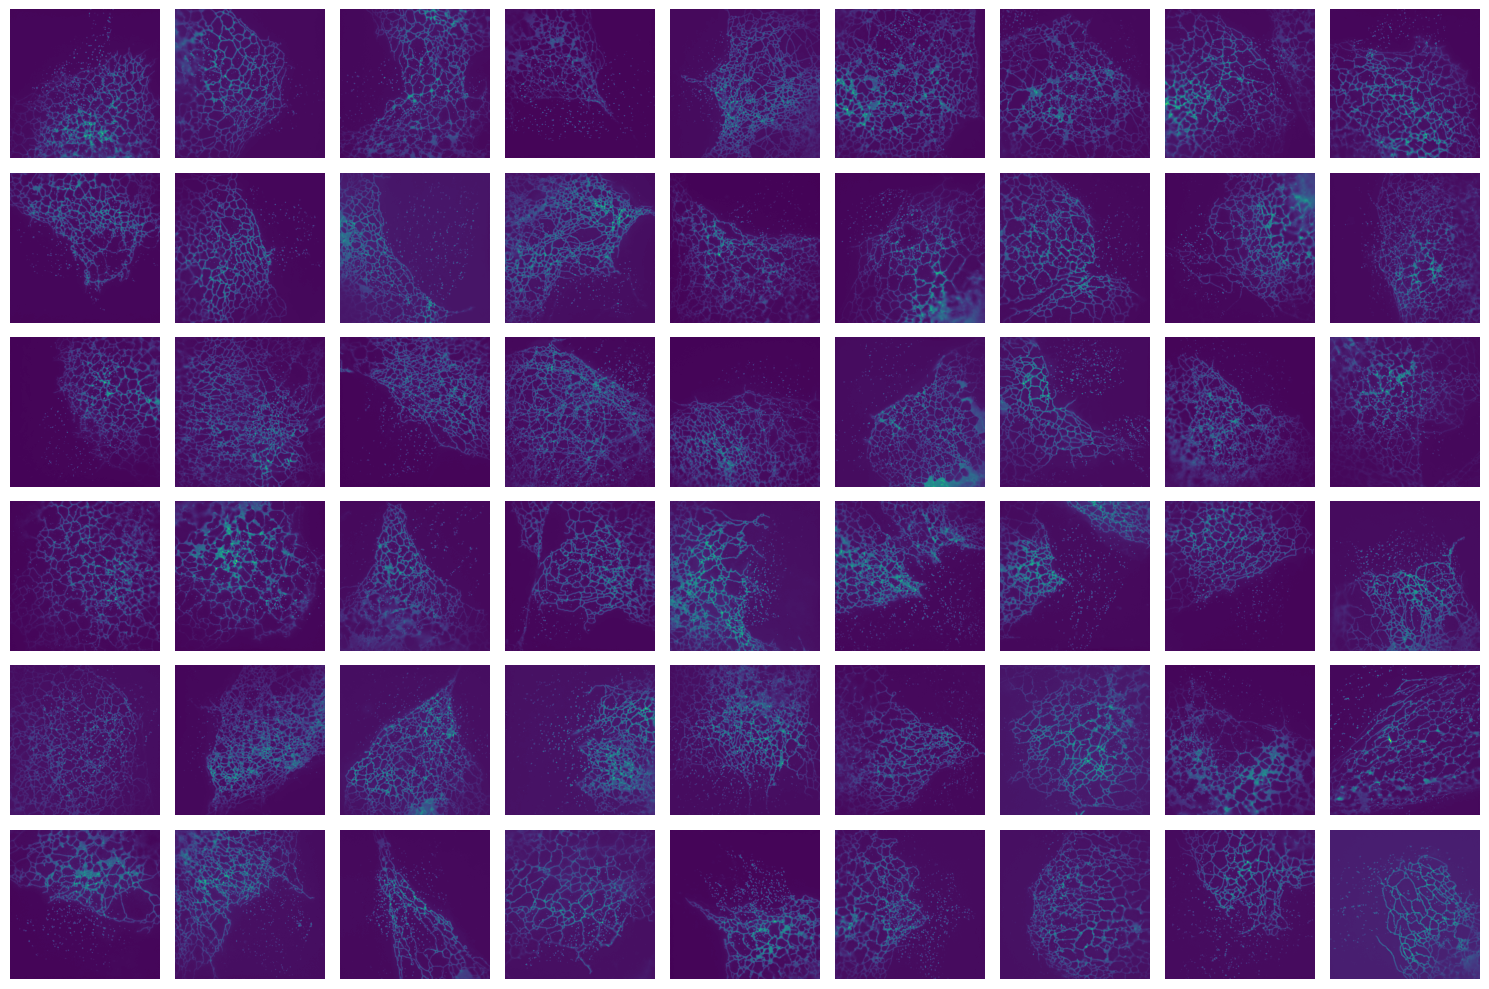

In [9]:
visualize_dataset(dataset)

In [10]:
# depths = [6, 6, 6, 6]
# num_heads = [6, 6, 6, 6]
depths = [3, 3]
num_heads = [3, 3]

from tests.training import Swin2SRModule
from configs.biosr_config import get_config

config = get_config()

# Initialize the model
model = Swin2SRModule(config)


model.load_state_dict(torch.load('/home/michele.prencipe/tesi/transformer/swin2sr/logdir/swin2sr_epoch400_valloss0.0000.pth'))

<All keys matched successfully>

## Inference

In [17]:
from loss.charbonnier_loss import CharbonnierLoss
from torch import nn as nn
# Validation loop (optional but recommended)
model.eval()  # Set model to evaluation mode
model = model.cuda()

criterion = nn.MSELoss()
val_loss = 0.0
test_inputs = []
test_outputs = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Ensure inputs and targets have the correct dimensions
        if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
            inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
            targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]

        outputs = model(inputs)  # Forward pass
        
        test_inputs.append(inputs.cpu().numpy())
        test_outputs.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())

        # Ensure outputs and targets have the same dimensions for loss computation
        if outputs.shape != targets.shape:
            print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
            raise ValueError("Output and target shapes do not match!")
        
        loss = criterion(outputs, targets)  # Compute loss
        val_loss += loss.item()  # Accumulate loss

test_inputs = np.concatenate(test_inputs, axis=0)
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Compute average validation loss for the epoch
val_loss = val_loss / len(test_loader)
print(f'Validation Loss: {val_loss:.9f}')


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Validation Loss: 0.000029688


## Metric Calculation

In [12]:
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.util_calculate_psnr_ssim import calculate_psnr, calculate_ssim

psnr_arr = {0: [], 1: []}
ssim_arr = defaultdict(list)

for i in range(len(test_inputs)):
    for ch_idx in range(test_outputs.shape[1]):
        psnr_arr[ch_idx].append(psnr(test_targets[i,ch_idx], test_outputs[i,ch_idx], data_range=1.0))
        ssim_arr[ch_idx].append(ssim(test_targets[i,ch_idx], test_outputs[i,ch_idx], data_range=1.0))
    

In [13]:
print("psnr channel 1:", np.mean(psnr_arr[0]))
print("psnr channel 2:", np.mean(psnr_arr[1]))
print("ssim channel 1:", np.mean(ssim_arr[0]))
print("ssim channel 2:", np.mean(ssim_arr[1]))

#chiedere ad ashesh perchè i risultati cambiano ogni run
# qui vado a ricreare il dataset da capo, non uso lo stesso del training ed è per questo maybe che ci sono risultati cosi alti

psnr channel 1: 45.06519961049664
psnr channel 2: 44.274097014084425
ssim channel 1: 0.9950891314960226
ssim channel 2: 0.9205541301820492


## Visual Evaluation

Index: 5


Text(0.5, 1.0, 'Target')

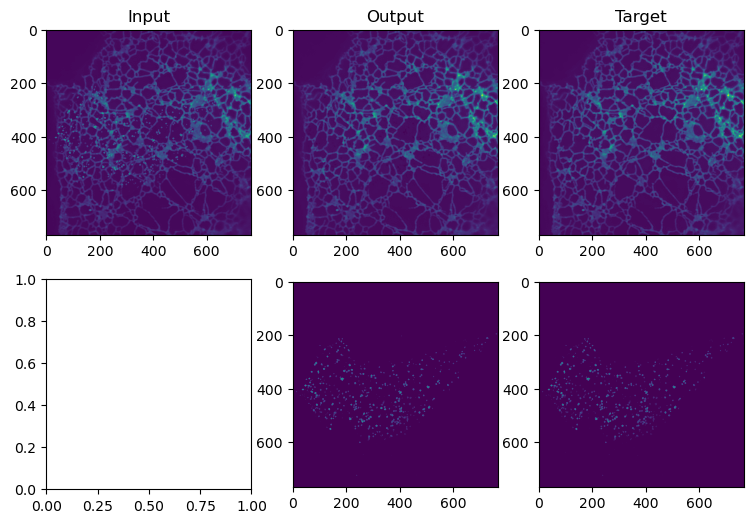

In [14]:
idx = np.random.randint(0,len(test_inputs))
print(f"Index: {idx}")
img_sz = 3
ncols = 3
nrows = 2
_, ax = plt.subplots(figsize=(img_sz*ncols, img_sz*nrows), ncols=ncols,nrows=nrows)
ax[0,0].imshow(test_inputs[idx,0])
ax[0,1].imshow(test_outputs[idx,0], vmax = np.max(test_targets[idx,0]), vmin=np.min(test_targets[idx,0]))
ax[0,2].imshow(test_targets[idx,0])
ax[1,1].imshow(test_outputs[idx,1], vmax = np.max(test_targets[idx,1]), vmin=np.min(test_targets[idx,1]))
ax[1,2].imshow(test_targets[idx,1])

ax[0,0].set_title('Input')
ax[0,1].set_title('Output')
ax[0,2].set_title('Target')